In [1]:
import torch 
from torch import nn, Tensor
import einops
import torchvision
import matplotlib.pyplot as plt

In [2]:
def create_saliency_map(eye, featmap_size, sigma=0.1):
    """
    Create a saliency map for the given eye position. It is scaled according to the size of the feature map.
    Args:
        eye (torch.Tensor): The eye position in the range [-1, 1] (x, y)
        featmap_size (tuple): The size of the feature map (height, width)
        sigma_ratio (float): Ratio of sigma to the feature map size. Default is 0.1 (10% of feature map size).
    """
    h_featmap, w_featmap = featmap_size
    batch_size = eye.shape[0]
    
    # Compute sigma based on the feature map size
    sigma = sigma * (h_featmap + w_featmap) / 2.0
    
    # Generate the meshgrid for the feature map size
    x = torch.arange(w_featmap, dtype=torch.float32, device=eye.device).view(1, -1).repeat(h_featmap, 1)
    y = torch.arange(h_featmap, dtype=torch.float32, device=eye.device).view(-1, 1).repeat(1, w_featmap)
    x, y = x.unsqueeze(0), y.unsqueeze(0)  # Add batch dimension
    
    # Expand meshgrid to batch size
    x = x.repeat(batch_size, 1, 1)
    y = y.repeat(batch_size, 1, 1)

    # Convert normalized coordinates to feature map indices
    eye_x = ((eye[:, 0] + 1) / 2).view(-1, 1, 1) * w_featmap
    eye_y = ((eye[:, 1] + 1) / 2).view(-1, 1, 1) * h_featmap
    
    # Calculate the Gaussian function
    gaussian = torch.exp(-(((x - eye_x) ** 2) / (2 * sigma ** 2) +
                           ((y - eye_y) ** 2) / (2 * sigma ** 2)))

    return gaussian

def crop(images: Tensor, crop_shape: tuple, gaze: Tensor = None, crop_is_random: bool =False):
    image_shape = images.shape[-2:]
    if crop_shape != image_shape:
        if crop_is_random:
            crop_indices = torchvision.transforms.RandomCrop.get_params(
                images, output_size=crop_shape
            )
            i, j, h, w = crop_indices  
        else:
            i = (image_shape[0] - crop_shape[0]) // 2
            j = (image_shape[1] - crop_shape[1]) // 2
            h = crop_shape[0]
            w = crop_shape[1]
        images = torchvision.transforms.functional.crop(images, i, j, h, w)
    else:
        i, j, h, w = 0, 0, image_shape[0], image_shape[1]

    if gaze is not None:
        gaze = torch.stack([
            (((gaze[..., 0]+1)/2) * image_shape[1] - j) / w * 2 - 1,
            (((gaze[..., 1]+1)/2) * image_shape[0] - i) / h * 2 - 1,
        ], dim=-1)

    return images, gaze
    


In [3]:
from gym_av_aloha.datasets.av_aloha_dataset import AVAlohaDataset
from torch.utils.data import DataLoader
# create dataset
fps = 8.33333333333333
observation_indices = [0]
observation_timestamps = [i/fps for i in observation_indices]
delta_timestamps = {
    "observation.images.zed_cam_left": observation_timestamps,
    "observation.images.zed_cam_right": observation_timestamps,
    "left_eye": observation_timestamps,
    "right_eye": observation_timestamps,
}
dataset = AVAlohaDataset(
    repo_id="iantc104/av_aloha_sim_hook_package", 
    delta_timestamps=delta_timestamps,
)

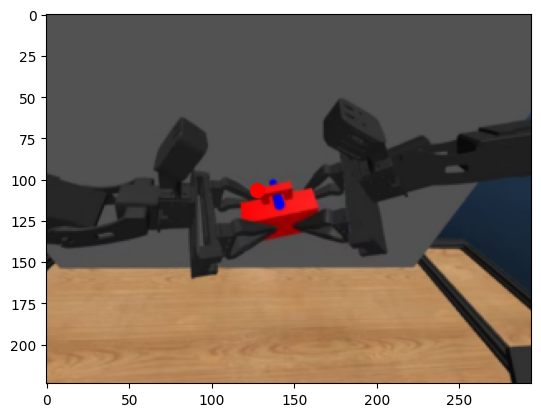

In [4]:
from torch.utils.data import DataLoader, Subset

dataloader = DataLoader(
    Subset(dataset, range(400, 500)),
    batch_size=32,
    shuffle=False,
    num_workers=0,
)
batch = next(iter(dataloader))
img = torch.stack([
    batch['observation.images.zed_cam_left'],
    batch['observation.images.zed_cam_right'],
], dim=2)
gaze = torch.stack([
    batch['left_eye'],
    batch['right_eye'],
], dim=2)

img = einops.rearrange(img, 'b s n c h w -> (b s n) c h w')
gaze = einops.rearrange(gaze, 'b s n c -> (b s n) c')

img, gaze = crop(img, (224, 294), gaze=gaze, crop_is_random=True)

plt.imshow((img[0]*255).permute(1, 2, 0).cpu().numpy().astype('uint8'))
plt.scatter(
    (gaze[0, 0] + 1) / 2 * img.shape[-1],
    (gaze[0, 1] + 1) / 2 * img.shape[-2],
    c='red',
    s=100,
)
plt.show()

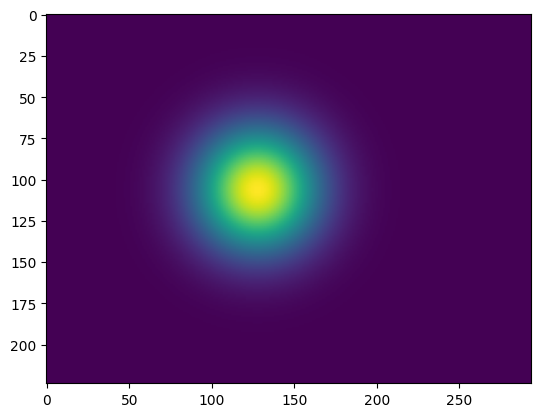

In [5]:
gaussian = create_saliency_map(
    gaze,
    featmap_size=(img.shape[-2], img.shape[-1]),
    sigma=0.1,
)
plt.imshow(gaussian[0].cpu().numpy())

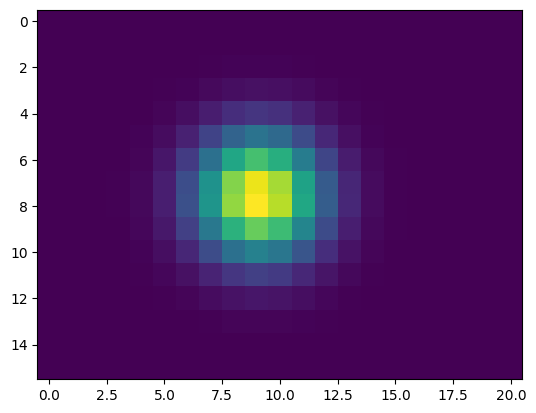

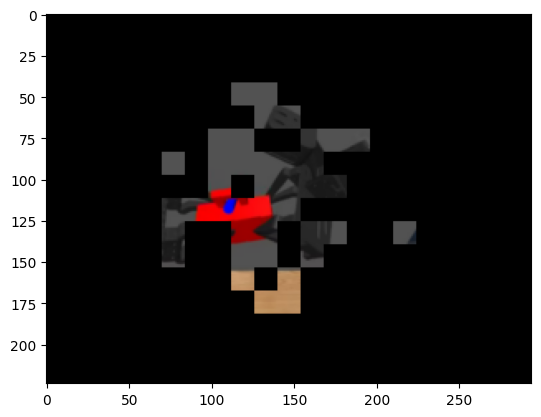

In [ ]:
def patchify(images, patch_size):
    """
    Args:
        images: Tensor of shape (B, C, H, W)
        patch_size: int or tuple (patch_h, patch_w)
    Returns:
        patches: Tensor of shape (B, num_patches, C, patch_h, patch_w)
    """
    if isinstance(patch_size, int):
        patch_h = patch_w = patch_size
    else:
        patch_h, patch_w = patch_size

    B, C, H, W = images.shape
    assert H % patch_h == 0 and W % patch_w == 0, "Image dimensions must be divisible by patch size"
    num_patches_h = H // patch_h
    num_patches_w = W // patch_w

    # Rearrange the image into patches
    patches = einops.rearrange(
        images, 
        'b c (nh ph) (nw pw) -> b (nh nw) c ph pw',
        ph=patch_h, pw=patch_w
    )
    return patches

def unpatchify(patches, image_size):
    """
    Args:
        patches: Tensor of shape (B, num_patches, C, patch_h, patch_w)
        image_size: tuple (H, W) of the output image
    Returns:
        images: Tensor of shape (B, C, H, W)
    """
    B, num_patches, C, patch_h, patch_w = patches.shape
    H, W = image_size
    num_patches_h = H // patch_h
    num_patches_w = W // patch_w
    assert num_patches == num_patches_h * num_patches_w, "Number of patches does not match image size"

    images = einops.rearrange(
        patches,
        'b (nh nw) c ph pw -> b c (nh ph) (nw pw)',
        nh=num_patches_h, nw=num_patches_w
    )
    return images

def select_patches(scores, patches, k=20, random=True):
    """
    prob_dist: (B, N)
    patches:   (B, N, ...)
    Returns:
        sampled_patches: (B, k, ...)
        indices:         (B, k)
    """
    B, N = scores.shape

    if random:
        indices = torch.multinomial(scores, num_samples=k, replacement=False)
    else:
        _, indices = torch.topk(scores, k, dim=1)

    # Proper indexing
    # Expand the batch indices to match the shape of indices
    batch_idx = torch.arange(B, device=indices.device).unsqueeze(1).expand(-1, k)

    sampled = patches[batch_idx, indices]  # (B, k, ...)

    return sampled, indices

# Example usage
patch_size = 14
min_k = 10
image_shape = img.shape[-2:]
patch_shape = (image_shape[0] // patch_size, image_shape[1] // patch_size)
patches = patchify(img, patch_size=patch_size)
scores = create_saliency_map(gaze, featmap_size=patch_shape, sigma=0.1)
plt.imshow(scores[0].cpu().numpy())
plt.show()

scores = einops.rearrange(scores, 'b h w -> b (h w)')
# choose random k from 0 to N
k = 40
sampled_patches, indices = select_patches(scores, patches, k=k, random=False)  # Sample 20 patches
canvas_patches = torch.zeros_like(patches)
batch_idx = torch.arange(sampled_patches.shape[0], device=sampled_patches.device).unsqueeze(1)
canvas_patches[batch_idx, indices] = sampled_patches
canvas = unpatchify(canvas_patches, image_size=image_shape)
plt.imshow((canvas[5]*255).permute(1, 2, 0).cpu().numpy().astype('uint8'))
plt.show()


In [8]:
dino = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14_reg').cuda()

Using cache found in /home/ianchuang/.cache/torch/hub/facebookresearch_dinov2_main
/home/ianchuang/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/ianchuang/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/ianchuang/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


In [9]:
def gaze_mask(gaze, patch_shape, sigma=0.1):
    scores = create_saliency_map(gaze, featmap_size=patch_shape, sigma=sigma)
    scores = einops.rearrange(scores, 'b h w -> b (h w)')
    k = torch.randint(20, scores.shape[1], (1,)).item()  # Randomly choose k from 1 to N
    indices = torch.multinomial(scores, num_samples=k, replacement=False)
    mask = torch.ones_like(scores, dtype=torch.bool)
    batch_idx = torch.arange(scores.shape[0], device=indices.device).unsqueeze(1).expand(-1, k)
    mask[batch_idx, indices] = False
    return mask

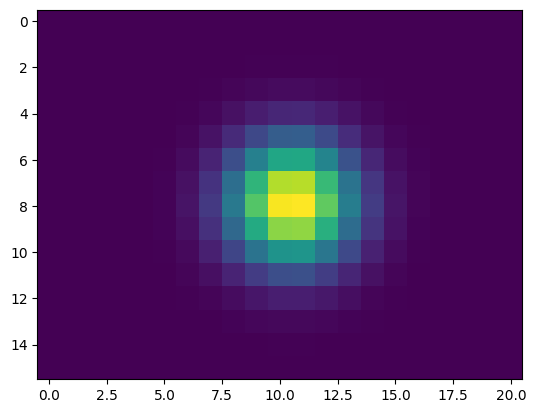

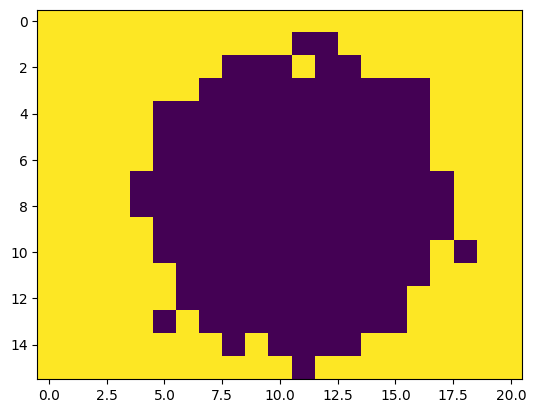

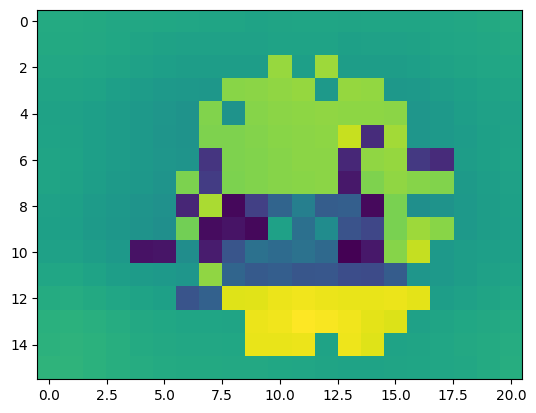

In [12]:
patch_size = 14
min_k = 10
image_shape = img.shape[-2:]
patch_shape = (image_shape[0] // patch_size, image_shape[1] // patch_size)

scores = create_saliency_map(gaze.cuda(), featmap_size=patch_shape, sigma=0.1)
plt.imshow(scores[0].cpu().numpy())
plt.show()

scores = einops.rearrange(scores, 'b h w -> b (h w)')
k = torch.randint(20, scores.shape[1], (1,)).item()  # Randomly choose k from 1 to N
indices = torch.multinomial(scores, num_samples=k, replacement=False)
# form mask
mask = torch.ones_like(scores, dtype=torch.bool)
batch_idx = torch.arange(scores.shape[0], device=indices.device).unsqueeze(1).expand(-1, k)
mask[batch_idx, indices] = False
plt.imshow(einops.rearrange(mask[0].cpu().numpy(), '(h w) -> h w', h=patch_shape[0], w=patch_shape[1]))
plt.show()

mask = gaze_mask(gaze.cuda(), patch_shape, sigma=0.1)

dino.eval()
normalize = torchvision.transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)
with torch.no_grad():
    features = dino.forward_features(normalize(img.cuda()), masks=mask)['x_norm_patchtokens']
features = einops.rearrange(features, 'b (h w) d -> b d h w', h=patch_shape[0], w=patch_shape[1])
plt.imshow(features[20].norm(dim=0).cpu().numpy())
plt.show()